In [99]:
import src.decorrelate as cluster_model
MODEL_NAME = 'EleutherAI/pythia-70m'
DATASET_NAME = 'NeelNanda/pile-10k'

N_DIMS = 512
SEED = 69_420
 
DEBUG = False
 
if DEBUG:
    N_DATASIZE = 300
    N_BLOCKS = 12
    STRING_SIZE_CUTOFF = 200
else:
    # It gets killed aroun 1_800 idk why. Maybe we have a problem with token truncation somewhere
    N_DATASIZE = 2_001 # TODO: was 3_000 for non-digraph
# 
    # N_CLUSTERS_MIN = int(0.5 * N_DIMS)
    # N_CLUSTERS_MAX = 10 * N_DIMS
    # TODO: DEL ME
    N_BLOCKS = 6
    STRING_SIZE_CUTOFF = 1_000

params = cluster_model.InterpParams(
	lattice_params=cluster_model.LatticeParams(
		top_layer_idx = -1,
        max_n_parents = 4
	),
    # quantization='4bit',
	seed=SEED,
    n_datasize=N_DATASIZE,
    n_blocks=N_BLOCKS,
    model_name=MODEL_NAME,
	model_n_dims=N_DIMS,
    dataset_name=DATASET_NAME,
    string_size_cutoff=STRING_SIZE_CUTOFF,
    quantization='4bit'
)

decomp = cluster_model.Decomposer(params)

Creating decomposer with parameter data hash cache/data-9ca1a7113cd59c0eaf97b97c20dd15e5b47664cf/start.pkl
Creating decomposer with parameter lattice hash cache/correlation-cf1e08d4f095000f1b6688a204d42b7c56a5d436/start.pkl
Created dataset


In [100]:
# TODO: make this a bit nicer with hooks
# But we are changing to GPTNeoxLayer to
"""
   class GPTNeoXLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.use_parallel_residual = config.use_parallel_residual
        self.input_layernorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.post_attention_layernorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.post_attention_dropout = nn.Dropout(config.hidden_dropout)
        self.post_mlp_dropout = nn.Dropout(config.hidden_dropout)
        self.attention = GPTNeoXAttention(config)
        self.mlp = GPTNeoXMLP(config)

    def forward(
        self,
        hidden_states: Optional[torch.FloatTensor],
        attention_mask: Optional[torch.FloatTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = False,
        layer_past: Optional[Tuple[torch.Tensor]] = None,
        output_attentions: Optional[bool] = False,
    ):
        attention_layer_outputs = self.attention(
            self.input_layernorm(hidden_states),
            attention_mask=attention_mask,
            position_ids=position_ids,
            layer_past=layer_past,
            head_mask=head_mask,
            use_cache=use_cache,
            output_attentions=output_attentions,
        )
        attn_output = attention_layer_outputs[0]  # output_attn: attn_output, present, (attn_weights)
        attn_output = self.post_attention_dropout(attn_output)
        outputs = list(attention_layer_outputs[1:])

        if self.use_parallel_residual:
            # pseudocode:
            # x = x + attn(ln1(x)) + mlp(ln2(x))
            mlp_output = self.mlp(self.post_attention_layernorm(hidden_states))
            mlp_output = self.post_mlp_dropout(mlp_output)
            hidden_states = mlp_output + attn_output + hidden_states
            # Override the present state to be the pre-residual stream addition
            outputs[0] = mlp_output + attn_output
        else:
            raise NotImplementedError
            # pseudocode:
            # x = x + attn(ln1(x))
            # x = x + mlp(ln2(x))
            attn_output = attn_output + hidden_states
            mlp_output = self.mlp(self.post_attention_layernorm(attn_output))
            mlp_output = self.post_mlp_dropout(mlp_output)
            hidden_states = mlp_output + attn_output

        outputs = tuple(outputs)
        if use_cache:
            outputs = (hidden_states,) + outputs  # hidden_states, present, (attn_weights)
        else:
            outputs = (hidden_states,) + outputs[1:]  # hidden_states, (attn_weights)

        return outputs

"""

'\n   class GPTNeoXLayer(nn.Module):\n    def __init__(self, config):\n        super().__init__()\n        self.use_parallel_residual = config.use_parallel_residual\n        self.input_layernorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)\n        self.post_attention_layernorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)\n        self.post_attention_dropout = nn.Dropout(config.hidden_dropout)\n        self.post_mlp_dropout = nn.Dropout(config.hidden_dropout)\n        self.attention = GPTNeoXAttention(config)\n        self.mlp = GPTNeoXMLP(config)\n\n    def forward(\n        self,\n        hidden_states: Optional[torch.FloatTensor],\n        attention_mask: Optional[torch.FloatTensor] = None,\n        position_ids: Optional[torch.LongTensor] = None,\n        head_mask: Optional[torch.FloatTensor] = None,\n        use_cache: Optional[bool] = False,\n        layer_past: Optional[Tuple[torch.Tensor]] = None,\n        output_attentions: Optional[bool] = F

In [101]:
decomp.model[0].forward?

Signature:      
decomp.model[0].forward(
    input_ids: Optional[torch.LongTensor] = None,
    attention_mask: Optional[torch.FloatTensor] = None,
    position_ids: Optional[torch.LongTensor] = None,
    inputs_embeds: Optional[torch.FloatTensor] = None,
    head_mask: Optional[torch.FloatTensor] = None,
    past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
    labels: Optional[torch.LongTensor] = None,
    use_cache: Optional[bool] = None,
    output_attentions: Optional[bool] = None,
    output_hidden_states: Optional[bool] = None,
    return_dict: Optional[bool] = None,
) -> Union[Tuple, transformers.modeling_outputs.CausalLMOutputWithPast]
Call signature:  decomp.model[0].forward(*args, **kwargs)
Type:            partial
String form:    
functools.partial(<function add_hook_to_module.<locals>.new_forward at 0x7e3dfa5e3eb0>, GPTNeoXFo <...> ntwise_affine=True)
           )
           (embed_out): Linear(in_features=512, out_features=50304, bias=False)
           ))

In [102]:
# https://sporco.readthedocs.io/en/latest/examples/dl/cmod.h
decomp.load(reload=False)

Loading dataset from cache
Got embeddings
Using saved correlation for layer 0
Using saved correlation for layer 1
Using saved correlation for layer 2
Using saved correlation for layer 3
Using saved correlation for layer 4
Using saved correlation for layer 5


## Try Something Like a NMF Decomposition

In [185]:
from sklearn.decomposition import NMF

D_SCALE = 2
LAYER = 2

model = NMF(n_components=N_DIMS * 2 * D_SCALE, l1_ratio=1, init='random', alpha_W=1, alpha_H=1)
# TODO: delete diagonals?
B = model.fit(decomp.internal_correlations[LAYER])


## Try to do dictionary learning on the correlation lattice

In [103]:
import importlib
import src.model as smodel
import torch
from torch.utils.data import DataLoader, TensorDataset
# import SparseAutoencoder, train_autoencoder
importlib.reload(smodel)

D_SCALE = 3
LAYER = 2

if False:
    # hidden_size = 10  # Number of hidden units
    autoencoder = smodel.SparseAutoencoder(N_DIMS * 2, N_DIMS * 2 * D_SCALE, beta=1, lamda=0.001)
    
    # # Train the autoencoder
    dataset = TensorDataset(torch.FloatTensor(decomp.internal_correlations[LAYER]))
    smodel.train_autoencoder(autoencoder, dataset, num_epochs=100, batch_size=32)

In [179]:
"""
What's the idea here?

The i

"""
from sklearn.decomposition import DictionaryLearning
import numpy as np

D_SCALE = 3

internal_corrs = np.array(decomp.internal_correlations[LAYER])

# Hrmm why would the below effect anything?
# for i in range(N_DIMS * 2):
#     internal_corrs[i, i] = 0.0

d = DictionaryLearning(n_components=N_DIMS * 2 * D_SCALE, alpha=100, fit_algorithm='cd', max_iter=3_000, transform_alpha=5, positive_dict=True)
dfit = d.fit(internal_corrs)

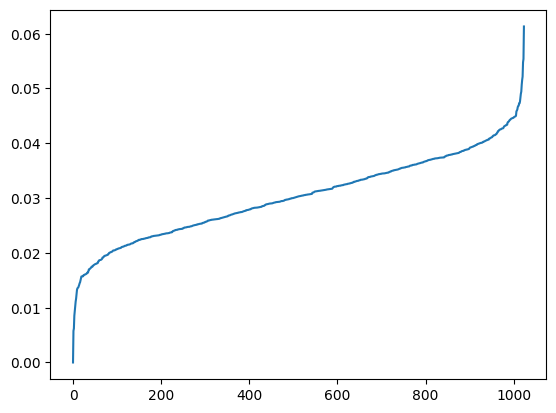

In [181]:
import matplotlib.pyplot as plot

a = np.array(dfit.components_[0])
a.sort()
plot.plot(a)

In [182]:
X = dfit.transform(internal_corrs)

In [183]:
dfit.components_[1].max(), decomp.internal_correlations[LAYER][0]

(0.06115304998789689,
 array([1.        , 0.        , 0.45802488, ..., 0.56535323, 0.75646269,
        0.2358806 ]))

In [184]:
idx = 100
reconstr = None
for i in X[idx].nonzero()[0]:
    if reconstr is None:
        reconstr = dfit.components_[i] * X[idx][i]
    else: reconstr += dfit.components_[i] * X[idx][i]

diff = np.abs(reconstr - decomp.internal_correlations[LAYER][idx]).sum()
reconstr, decomp.internal_correlations[LAYER][idx], diff, X[idx][X[idx].nonzero()[0]], X[idx].nonzero()[0].shape

(array([0.4383516 , 0.54469093, 0.43880114, ..., 0.54261433, 0.66154967,
        0.33102909]),
 array([0.43885553, 0.54500787, 0.43904086, ..., 0.54414296, 0.66130015,
        0.32963073]),
 0.8066932876278969,
 array([ 2.14876224e-02,  1.76223953e-02,  1.00580212e-01, -3.38107774e-02,
        -4.27012532e-02, -8.87312513e-02,  7.94235353e-02,  6.12939324e-02,
        -5.07053268e-02,  7.34634308e-02,  1.06779902e-01,  9.46318141e-02,
        -7.62439501e-02,  1.17583990e-01,  4.86965965e-02,  9.42712537e-02,
         5.26422502e-02,  1.38234717e-03,  1.97326045e-02, -5.31515318e-03,
        -1.74065600e-02, -4.08712222e-02,  1.41207139e-02,  1.01808929e-01,
         1.47019928e-02,  4.49928121e-02,  7.04316908e-02, -5.21354346e-02,
         6.38773643e-02,  1.58208917e-02,  1.07919003e-01,  4.52938226e-02,
         5.15131876e-02,  1.13757450e-01,  6.71773751e-02,  9.55582346e-02,
         1.81891533e-02,  5.38486439e-02, -6.68131690e-03,  9.25226148e-02,
         1.25199303e-01,  6.0

## Build Up a "Concept" Lattice Using Graph Restrictions

> TODO: this is for latter...

In [109]:
import src.graph as graph
import networkx as nx

LAYER = 3

G = graph.di_graph_from_correlations(decomp.internal_correlations[LAYER])
MAX_CLIQUE_SIZE = 1_000

In [110]:
GG = graph.sparsify_weighted_digraph(G, degree_upperbound=50)

In [111]:
nx.is_connected(GG)

NetworkXNotImplemented: not implemented for directed type

In [ ]:
cc = []
for j in range(1_024):
    c = GG.get_edge_data(0, j)
    if c is not None:
        cc.append(c['weight'])
cc.sort()
cc

[0.7804636816254003,
 0.7813018624377651,
 0.7817276582904464,
 0.7819791125341559,
 0.782213803161618,
 0.7823479120915964,
 0.7833436708966859,
 0.7835247179521566,
 0.7869411429433557,
 0.7878128509882152,
 0.7910716979866896,
 0.7912192178096659,
 0.79138014852564,
 0.7920272241127856,
 0.7953866528087439,
 0.7988600740951838,
 0.80074430456138,
 0.8030811526662531,
 0.8040802641945921,
 0.8048480378187183,
 0.8060449600187752,
 0.8073391111930666,
 0.8090758218362866,
 0.8101017551506211,
 0.8137763398320286,
 0.8160193116859169,
 0.8231539067607664,
 0.8258427908068329,
 0.8313479623824451,
 0.8318173436373695,
 0.8386602517895161,
 0.8412820813705932,
 0.8418151643672573,
 0.8424857090171491,
 0.8467771947764572,
 0.847658960991065,
 0.8497845875312222,
 0.8533854123011416,
 0.8545387490989557,
 0.8598863426818433,
 0.8603825457227633,
 0.8661056443095905,
 0.8667191926642416,
 0.8674266172698775,
 0.8727473890667695,
 0.8749501282416643,
 0.8766365480361423,
 0.8823227666672254

In [ ]:
next(i)

NameError: name 'i' is not defined

In [ ]:
GG.get_edge_data

In [ ]:
import importlib
import src.utils as utils
importlib.reload(utils)

decomp.tune_clique((0.0, clique), 3)

<module 'src.utils' from '/home/lev/code/research/ai/lattice_cluster_paths/src/utils.py'>

In [ ]:
# import networkx as nx

# test_at = 100
# GG = graph.sparsify_weighted_graph(G, degree_upperbound=test_at)

# cliques = []

# for node in range(N_DIMS * 2):
#     if node % 50 == 0:
#         print("On node", node)
#     c_it = nx.find_cliques(GG, nodes=[node])
#     c_in_curr = []
#     for c in c_it:
#         c_in_curr.append(c)
#         if len(c_in_curr) > 50:
#             break
#     cliques += c_in_curr
#         # if len(cliques) > 10_000:
#         #     break

## Score a cell

In [ ]:
decomp.internal_correlations[0]

array([[1.        , 0.        , 0.50411391, ..., 0.41980654, 0.47819793,
        0.52677501],
       [0.        , 1.        , 0.51517917, ..., 0.56102004, 0.50169823,
        0.55460722],
       [0.50411391, 0.51517917, 1.        , ..., 0.47680901, 0.5166343 ,
        0.52601947],
       ...,
       [0.41980654, 0.56102004, 0.47680901, ..., 1.        , 0.40289529,
        0.57754201],
       [0.47819793, 0.50169823, 0.5166343 , ..., 0.40289529, 1.        ,
        0.        ],
       [0.52677501, 0.55460722, 0.52601947, ..., 0.57754201, 0.        ,
        1.        ]])

In [ ]:
import src.decorrelate as decc
import src.kernel as kernel
importlib.reload(decc)
importlib.reload(utils)
importlib.reload(kernel)

LAYER = 2
NEURON = 2

# TODO: we **need** to do something like curr-clique removal so we get more interesting cliques...
# Also the per-neuron thing makes no sense...

# TODO: change size of subset??
decomp.scores_for_neuron(LAYER, NEURON, degree_upperbound=400, n_features_per_neuron=3)

GOT CLIQUES WITH LENGTH [9, 9, 10] [(23.79445227225935, [2, 771, 128, 217, 389, 593, 657, 661, 785]), (25.24844098956523, [2, 771, 128, 217, 389, 593, 657, 687, 936]), (29.81072255571707, [2, 771, 128, 217, 389, 593, 657, 687, 785, 613])]
Got tuned clique [0.0, 0.8, 0.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.6]
Got tuned clique [0.0, 0.0, 0.0, 0.4, 1.0, 1.0, 1.0, 0.6, 0.0]
Got tuned clique [0.0, 0.8, 0.0, 0.6, 1.0, 1.0, 1.0, 1.0, 0.6, 1.0]
Finished for neuron 2 2
